# Basins

This tutorial demonstrates using PyWBT to delineate basins for a watershed in London. We use NASADEM to download the DEM data and delineate the basins using PyWBT.

In [1]:
from __future__ import annotations

import shutil
from pathlib import Path

import geopandas as gpd
import planetary_computer
import pystac_client
import rasterio
import rioxarray
import rioxarray.merge as rxr_merge
import shapely
from rasterio import features

from pywbt import whitebox_tools

We use Microsoft Planetary Computer to access the NASADEM data. FOr this purpose, we need `planetary_computer` and `pystac_client` package. You can install it using `pip install planetary_computer pystac_client`.

In [2]:
fname = Path("dem.tif")
if not fname.exists():
    bbox = (0.0337, 51.5477, 0.1154, 51.6155)
    gdf = gpd.GeoSeries(shapely.box(*bbox), crs=4326)
    utm = gdf.estimate_utm_crs()
    bbox_utm = gdf.to_crs(utm).total_bounds
    bbox_buff = gdf.to_crs(utm).buffer(20*30).to_crs(4326).total_bounds
    catalog = pystac_client.Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )
    search = catalog.search(
        collections=["nasadem"],
        bbox=bbox_buff,
    )
    signed_asset = (
        planetary_computer.sign(item.assets["elevation"]).href
        for item in search.items()
    )
    dem = rxr_merge.merge_arrays(
        [rioxarray.open_rasterio(href).squeeze(drop=True) for href in signed_asset]
    )
    dem = dem.rio.reproject(utm).fillna(dem.rio.nodata)
    dem = dem.rio.clip_box(*bbox_utm).astype("int16")
    dem.rio.to_raster(fname)

For working with PyWBT, you need give the sequence of the WBT tools that you want to invoke with their respective parameters. In this example, we use the following sequence of tools:

1. `BreachDepressions`: An alternative to filling depressions in a DEM. This tool modifies the DEM to remove all depressions and flat areas, allowing water to flow off the edge of the DEM.
2. `D8Pointer`: A tool for generating flow pointer grid using the simple D8 algorithm.
3. `D8FlowAccumulation`: A tool for computing flow accumulation grid using the D8 algorithm.
4. `ExtractStreams`: A tool for extracting stream channels from a flow accumulation grid.
5. `FindMainStem`: A tool for finding the main stem of a stream network.
6. `StrahlerStreamOrder`: A tool for computing the Strahler stream order of a stream network.
7. `Basins`: A tool for automatic delineation of basins from a flow accumulation grid.

In [3]:
work_dir = Path("results")
work_dir.mkdir(exist_ok=True)
shutil.copy(fname, work_dir)
wbt_args = {
    "BreachDepressions": [f"-i={fname}", "--fill_pits", "-o=dem_corr.tif"],
    "D8Pointer": ["-i=dem_corr.tif", "-o=fdir.tif"],
    "D8FlowAccumulation": ["-i=fdir.tif", "--pntr", "-o=d8accum.tif"],
    "ExtractStreams": ["--flow_accum=d8accum.tif", "--threshold=600.0", "-o=streams.tif"],
    "FindMainStem": ["--d8_pntr=fdir.tif", "--streams=d8accum.tif", "-o=mainstem.tif"],
    "StrahlerStreamOrder": ["--d8_pntr=fdir.tif", "--streams=streams.tif", "-o=strahler.tif"],
    "Basins": ["--d8_pntr=fdir.tif", "-o=basins.tif"],
}
whitebox_tools(wbt_args, work_dir="results")

We can take a look at the Strahler stream order and the basins delineated for the watershed.

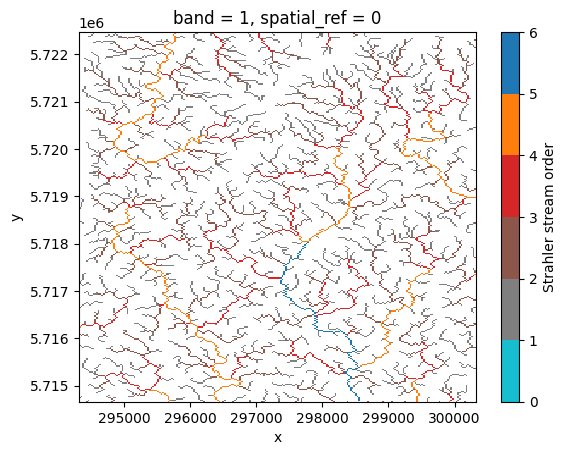

In [4]:
stream_order = rioxarray.open_rasterio(f"{work_dir}/strahler.tif").squeeze()
stream_order = stream_order.astype("uint8")
stream_order.attrs["name"] = "strahler"
stream_order.attrs["long_name"] = "Strahler stream order"
levels = range(stream_order.max().item() + 1)
ax = stream_order.where(stream_order > 0).plot.imshow(robust=False, levels=levels, cmap="tab10_r")
ax.figure.savefig("stream_order.png")

In [5]:
with rasterio.open(f"{work_dir}/basins.tif") as src:
    data = src.read(1).astype("int32")
    feats_gen = features.shapes(
        data,
        mask=data != src.nodata,
        transform=src.transform,
        connectivity=8,
    )
    basin_geo = gpd.GeoDataFrame.from_features([
        {"geometry": geom, "properties": {"basin": val}} for geom, val in list(feats_gen)
    ], crs=src.crs)
    basin_geo["basin"] = basin_geo["basin"].astype("int32")
basin_geo.loc[[basin_geo.area.idxmax()]].explore()